In [1]:
import os
import sys
import glob
import shutil
import warnings
from datetime import datetime
from timeit import default_timer as timer

print("")
print("+"*shutil.get_terminal_size().columns)
print("Hierarchical Bayesian Analysis of Kepler Eccentricities")
print("Initialized {0}".format(datetime.now().strftime("%d-%b-%Y at %H:%M:%S")))
print("+"*shutil.get_terminal_size().columns)
print("")

# track date
YYYYMMDD = datetime.now().strftime("%Y%m%d")

# start program timer
global_start_time = timer()


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Hierarchical Bayesian Analysis of Kepler Eccentricities
Initialized 29-Aug-2024 at 09:42:32
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



## Set arguments

In [2]:
# set paths
PROJECT_DIR   = '/Users/research/projects/kepler-ecc-rp/'
DR25_DATA_DIR = '/Users/research/data/DR25_chains/'

# set variables
NSAMP = 1000

# select population
POPULATION = 'singles'

if POPULATION == 'singles':
    ALDERAAN_DATA_DIR = '/Users/research/projects/alderaan/Results/ecc-singles-LC-2024-08-26/'
    MULTIPLICITY = (1,1)
    
elif POPULATION == 'multis':
    ALDERAAN_DATA_DIR = '/Users/research/projects/alderaan/Results/ecc-multis-LC/'
    MULTIPLICITY = (2,99)
    
    
# set limits on star and planet properties
PER_LIM   = (1,100)
RAD_LIM   = (0.5,16)
MSTAR_LIM = (0.,10.)
RSTAR_LIM = (0.7,1.4)
FEH_LIM   = (-0.5,0.5)
TEFF_LIM  = (4700,6500)
AGE_LIM   = (0,14)

## Import packages and define constants

In [3]:
import astropy.constants as apc
from   copy import deepcopy
import diptest
import h5py
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from   matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

sys.path.append(PROJECT_DIR)
from utils.astro import calc_T14_circ, calc_sma, calc_aRs, jacobian, detection_prior, duration_ratio
from utils.eccsamp import imp_sample_rhostar
from utils.io import load_dr25_data_from_hdf5
from utils.stats import weighted_percentile, draw_random_samples, gelman_rubin

sys.path.append('/Users/research/projects/alderaan/')
from alderaan.Results import Results

pi = np.pi

RSAU = (apc.R_sun/apc.au).value                                 # solar radius [AU]
RSRE = (apc.R_sun/apc.R_earth).value                            # R_sun/R_earth
RHOSUN_GCM3 = (3*apc.M_sun/(4*pi*apc.R_sun**3)).value/1000      # solar density [g/cm^3]

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


## Load data

In [4]:
print("Loading data...")

Loading data...


#### Load DR25 catalog

In [5]:
DR25_CATALOG = os.path.join(PROJECT_DIR, 'Catalogs/kepler_dr25_gaia_dr2_crossmatch.csv')
catalog = pd.read_csv(DR25_CATALOG, index_col=0)

# hard-code period and radius limits
use  = (catalog.period > 1) * (catalog.period < 300)
use *= (catalog.rp > 0) * (catalog.rp < 16)

# remove likely false positives
use *= (catalog.fpp < 0.1) + (catalog.disposition == 'CONFIRMED')

# require better than 20% precision on radius
#use *= catalog.rp_err/catalog.rp < 0.2

# clean up stellar sample
use *= catalog.logg > 4.0                                 # surface gravity as proxy for main sequence
use *= (catalog.rcf - 1 < 0.05) + np.isnan(catalog.rcf)   # radius correction factor (Furlan+ 2017)
use *= catalog.ruwe < 1.4                                 # Gaia RUWE

# slice subpopulation
use *= ((catalog.npl >= MULTIPLICITY[0]) &
        (catalog.npl <= MULTIPLICITY[1]) &
        (catalog.period >= PER_LIM[0]) &
        (catalog.period <= PER_LIM[1]) &
        (catalog.mstar >= MSTAR_LIM[0]) &
        (catalog.mstar <= MSTAR_LIM[1]) &
        (catalog.rstar >= RSTAR_LIM[0]) &
        (catalog.rstar <= RSTAR_LIM[1]) &
        (catalog.feh >= FEH_LIM[0]) &
        (catalog.feh <= FEH_LIM[1]) &
        (catalog.teff >= TEFF_LIM[0]) &
        (catalog.teff <= TEFF_LIM[1]) &
        (catalog.age >= AGE_LIM[0]) &
        (catalog.age <= AGE_LIM[1])
       )

# update targets and catalog
catalog = catalog.loc[use].reset_index(drop=True)
targets = np.array(catalog.planet_name)

#### Load posterior chains

In [6]:
def infer_planet_koi_from_period(star_koi, P_samp, catalog):
    P_all = catalog.loc[catalog.koi_id==star_koi, 'period'].values
    P_cat = P_all[np.argmin(np.abs(P_all - P_samp))]
        
    return catalog.loc[catalog.period==P_cat, 'planet_name'].values[0]

In [7]:
def infer_index_from_planet_koi(planet_koi, results, catalog):
    periods = np.zeros(results.npl)

    for n in range(results.npl):
        periods[n] = np.median(results.samples(n).PERIOD)
    
    return np.argmin(np.abs(periods - catalog.loc[catalog.planet_name==planet_koi, 'period'].values))    

In [8]:
failure = []
dr25_chains = {}
alderaan_chains = {}

# read in DR25 data
print("Loading DR25 data")
CHAINS = os.path.join(DR25_DATA_DIR, 'dr25-chains_trimmed-thinned.hdf')

for i, t in enumerate(targets):
    try:
        dr25_chains[t] = pd.DataFrame(load_dr25_data_from_hdf5(CHAINS, t))
        dr25_chains[t]['DUR14'] = calc_T14_circ(dr25_chains[t].PERIOD, 
                                                dr25_chains[t].ROR, 
                                                dr25_chains[t].IMPACT, 
                                                dr25_chains[t].RHOTILDE
                                               )

        if np.any(dr25_chains[t].values < 0):
            raise ValueError("Negative values in posterior chain")
        if np.sum(np.isnan(dr25_chains[t].values)) > 0:
            raise ValueError("NaN values in posterior chain")

    except:
        #warnings.warn("{0} failed to load".format(t))
        failure.append(t)

        
# read in ALDERAAN data
print("Loading ALDERAAN data")
files = np.sort(glob.glob(os.path.join(ALDERAAN_DATA_DIR, '*/*results.fits')))

for i, t in enumerate(targets):
    try:
        results = Results(t[:-3], ALDERAAN_DATA_DIR)
        n = infer_index_from_planet_koi(t, results, catalog)

        alderaan_chains[t] = results.samples(n).sample(n=8000, replace=True, weights=results.posteriors.weights(), ignore_index=True)
        alderaan_chains[t] = alderaan_chains[t].drop(columns='LN_WT')
        alderaan_chains[t] = alderaan_chains[t].rename(columns={'T0':'EPOCH'})

    except:
        #warnings.warn("{0} failed to load".format(t))
        failure.append(t)


# update targets and catalog
targets = list(np.array(targets)[~np.isin(targets,failure)])
catalog = catalog.loc[np.isin(catalog.planet_name, targets)].reset_index(drop=True)

print("{0} targets loaded".format(len(targets)))

Loading DR25 data
Loading ALDERAAN data
848 targets loaded


#### Sanitize chains

In [9]:
failure = []

for i, t in enumerate(targets):
    # remove grazing transits
    if np.any(dr25_chains[t].IMPACT.values  > 1 - dr25_chains[t].ROR.values):
        failure.append(t)

    # eliminate NaN and zero-valued chains
    if np.any(dr25_chains[t].values < 0):
        failure.append(t)
    if np.sum(np.isnan(dr25_chains[t].values)) > 0:
        failure.append(t)

    # check Gelman-Rubin convergence statistic
    for k in dr25_chains[t].keys():
        Rhat = gelman_rubin(dr25_chains[t][k].values.reshape(4,-1))
        if Rhat > 1.05:
            failure.append(t)

    # check Hartigan dip test for multimodality
    for k in dr25_chains[t].keys():
        dip, pval = diptest.diptest(dr25_chains[t][k].values)
        if pval < 0.05:            
            failure.append(t)

# update targets and catalog
targets = list(np.array(targets)[~np.isin(targets,failure)])
catalog = catalog.loc[np.isin(catalog.planet_name, targets)].reset_index(drop=True)

print("{0} targets found with unreliable chains".format(len(np.unique(failure))))

54 targets found with unreliable chains


#### Grab stellar densities

In [10]:
density = {}
failure = []

for i, t in enumerate(targets):
    try:
        use = catalog.planet_name == t
        
        rho_mu = catalog.loc[use, 'rhostar'].iloc[0]
        rho_err1 = np.abs(catalog.loc[use, 'rhostar_err1'].iloc[0])
        rho_err2 = np.abs(catalog.loc[use, 'rhostar_err2'].iloc[0])

        # don't use highly asymmetric density constraints
        if np.abs(rho_err1-rho_err2)/(0.5*(rho_err1+rho_err2)) > 0.30:
            failure.append(t)
        else:
            density[t] = rho_mu, np.sqrt(rho_err1**2 + rho_err2**2)/np.sqrt(2)
    
    except:
        warnings.warn("{0} has no recorded density".format(t))
        failure.append(t)

        
# update targets and catalog
targets = list(np.array(targets)[~np.isin(targets,failure)])
catalog = catalog.loc[np.isin(catalog.planet_name, targets)].reset_index(drop=True)

print("{0} targets found with missing or unreliable densities".format(len(np.unique(failure))))

5 targets found with missing or unreliable densities


## Importance sample $\{e,\omega,\rho_\star\}$

In [11]:
print("Importance sampling...")

Importance sampling...


In [12]:
failure = []
dr25_samples = {}
alderaan_samples = {}

for i, t in enumerate(targets):
    try:
        # true stellar density (tuple) in g/cm3
        rho_true = 1.41*density[t][0], 1.41*density[t][1]

        # DR25
        w, d = imp_sample_rhostar(dr25_chains[t], rho_true, ew_obs_prior=False, upsample=100)
        d = d.sample(n=NSAMP, replace=True, weights=w, ignore_index=True)
        J = jacobian(d.PERIOD, d.ROR, d.IMPACT, d.DUR14)
        d = d.sample(n=NSAMP, replace=True, weights=1/np.abs(J), ignore_index=True)

        dr25_samples[t] = d
        
        # ALDRAAN
        w, d = imp_sample_rhostar(alderaan_chains[t], rho_true, ew_obs_prior=False, upsample=100)
        d = d.sample(n=NSAMP, replace=True, weights=w, ignore_index=True)
        
        alderaan_samples[t] = d

    except:
        warnings.warn("{0} failed during sampling and will not be included in the analysis".format(t))
        failure.append(t)

    
# update targets and catalog
targets = list(np.array(targets)[~np.isin(targets,failure)])
catalog = catalog.loc[np.isin(catalog.planet_name, targets)].reset_index(drop=True)

/var/folders/f5/94803ccd3kl1b6yw01k2zj0m0000gn/T/ipykernel_20114/1696434106.py:25: UserWarning: K00891.01 failed during sampling and will not be included in the analysis
  warnings.warn("{0} failed during sampling and will not be included in the analysis".format(t))
/var/folders/f5/94803ccd3kl1b6yw01k2zj0m0000gn/T/ipykernel_20114/1696434106.py:25: UserWarning: K01204.01 failed during sampling and will not be included in the analysis
  warnings.warn("{0} failed during sampling and will not be included in the analysis".format(t))
/var/folders/f5/94803ccd3kl1b6yw01k2zj0m0000gn/T/ipykernel_20114/1696434106.py:25: UserWarning: K06776.01 failed during sampling and will not be included in the analysis
  warnings.warn("{0} failed during sampling and will not be included in the analysis".format(t))


## Make updated catalogs

In [13]:
catalog_keys = 'period ror dur14 impact ecc'.split()
samples_keys = 'PERIOD ROR DUR14 IMPACT ECC'.split()

dr25_catalog = pd.DataFrame(np.copy(targets), columns=['planet_name'])
alderaan_catalog = pd.DataFrame(np.copy(targets), columns=['planet_name'])

for k in catalog_keys:
    dr25_catalog[k+'_16'] = np.zeros(len(targets))
    dr25_catalog[k+'_50'] = np.zeros(len(targets))
    dr25_catalog[k+'_84'] = np.zeros(len(targets))

    alderaan_catalog[k+'_16'] = np.zeros(len(targets))
    alderaan_catalog[k+'_50'] = np.zeros(len(targets))
    alderaan_catalog[k+'_84'] = np.zeros(len(targets))
    
    
for i, t in enumerate(targets):
    # DR25
    use = dr25_catalog.planet_name == t
    samples = dr25_samples[t]
    
    for j, ck in enumerate(catalog_keys):
        sk = samples_keys[j]

        dr25_catalog.loc[use, ck+'_16'] = np.percentile(samples[sk], 16)
        dr25_catalog.loc[use, ck+'_50'] = np.percentile(samples[sk], 50)
        dr25_catalog.loc[use, ck+'_84'] = np.percentile(samples[sk], 84)

    
    # ALDERAAN
    use = alderaan_catalog.planet_name == t
    samples = alderaan_samples[t]
    
    for j, ck in enumerate(catalog_keys):
        sk = samples_keys[j]

        alderaan_catalog.loc[use, ck+'_16'] = np.percentile(samples[sk], 16)
        alderaan_catalog.loc[use, ck+'_50'] = np.percentile(samples[sk], 50)
        alderaan_catalog.loc[use, ck+'_84'] = np.percentile(samples[sk], 84)

## Identify discrepancies between catalogs

In [14]:
from astropy.stats import mad_std

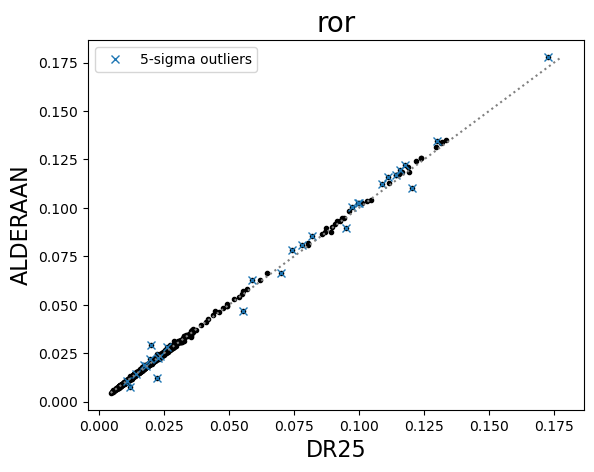

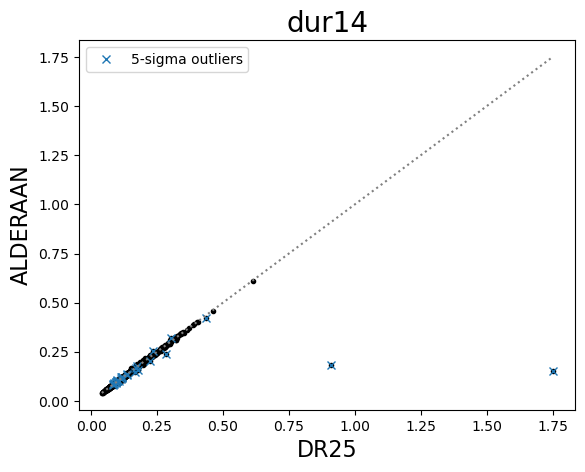

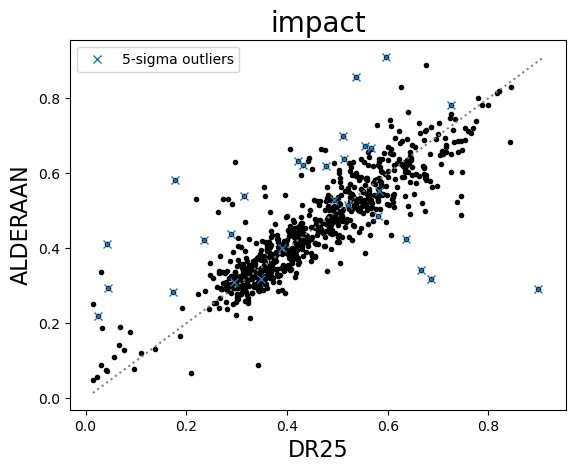

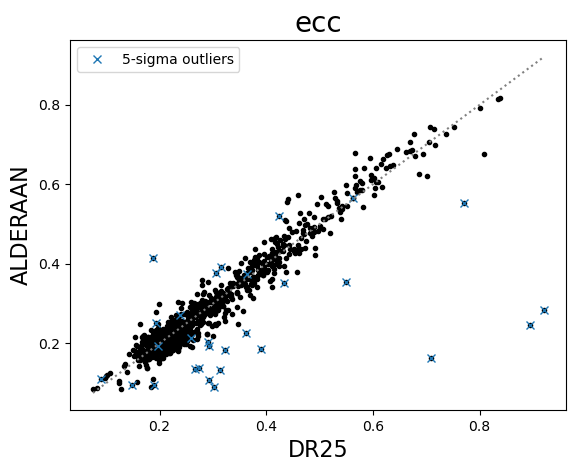

In [15]:
mismatch = []
sig_cut = 5

for k in ['ror', 'dur14', 'impact', 'ecc']:
    diff = dr25_catalog[k+'_50'] - alderaan_catalog[k+'_50']
    out  = np.abs(diff)/(1.4826*mad_std(diff)) > sig_cut
    
    mismatch.append(dr25_catalog.loc[out, 'planet_name'].values)
    
mismatch = np.sort(np.unique(np.hstack(mismatch)))


for k in ['ror', 'dur14', 'impact', 'ecc']:
    d_ = dr25_catalog[k+'_50']
    a_ = alderaan_catalog[k+'_50']
    x_ = np.linspace(np.hstack([a_,d_]).min(), np.hstack([a_,d_]).max())
    
    out = np.isin(dr25_catalog.planet_name, mismatch)
    
    if POPULATION == 'singles':
        color = 'C0'
    if POPULATION == 'multis':
        color = 'C1'
    if POPULATION == 'giants':
        color = 'C3'
    
    plt.figure()
    plt.plot(d_, a_, 'k.')
    plt.plot(d_.loc[out], a_.loc[out], 'x', color=color, label='{0}-sigma outliers'.format(sig_cut))
    plt.plot(x_, x_, ':', color='grey')
    plt.title(k, fontsize=20)
    plt.xlabel("DR25", fontsize=16)
    plt.ylabel("ALDERAAN", fontsize=16)
    plt.legend()
    plt.savefig("/Users/research/Desktop/tmp/ALDERAAN_DR25_compare_{0}_{1}.png".format(POPULATION, k))
    plt.show()

In [16]:
print(mismatch)

['K00063.01' 'K00128.01' 'K00135.01' 'K00188.01' 'K00196.01' 'K00201.01'
 'K00202.01' 'K00203.01' 'K00280.01' 'K00377.01' 'K00421.01' 'K00776.01'
 'K00809.01' 'K00824.01' 'K00850.01' 'K00883.01' 'K00897.01' 'K01101.01'
 'K01476.01' 'K01552.01' 'K01878.01' 'K02291.01' 'K03197.01' 'K03404.01'
 'K03484.01' 'K04178.01' 'K04820.01' 'K04853.01' 'K05117.01']


## Look at stars with mismatched planets

In [17]:
stars = []

for i, t in enumerate(mismatch):
    stars.append(t[:-3])

catalog.loc[np.isin(catalog.koi_id, stars), ['planet_name', 'period', 'rp']]

,planet_name,period,rp
4,K00063.01,9.434142,5.729292
11,K00128.01,4.942783,13.177194
12,K00135.01,3.024092,12.295560
18,K00188.01,3.797018,10.248299
23,K00196.01,1.855558,13.771029
27,K00201.01,4.225384,8.456989
28,K00202.01,1.720861,14.413139
29,K00203.01,1.485711,14.346738
39,K00280.01,11.872907,1.913040
55,K00377.01,19.270826,7.898448


In [18]:
alderaan_catalog.loc[np.isin(alderaan_catalog.planet_name, mismatch), ['planet_name', 'ecc_50']]

,planet_name,ecc_50
4,K00063.01,0.088939
11,K00128.01,0.095262
12,K00135.01,0.132218
18,K00188.01,0.183830
23,K00196.01,0.138287
27,K00201.01,0.094438
28,K00202.01,0.136419
29,K00203.01,0.109000
39,K00280.01,0.353002
55,K00377.01,0.108184


In [19]:
dr25_catalog.loc[np.isin(dr25_catalog.planet_name, mismatch), ['planet_name', 'ecc_50']]

,planet_name,ecc_50
4,K00063.01,0.301920
11,K00128.01,0.148834
12,K00135.01,0.313039
18,K00188.01,0.322283
23,K00196.01,0.273421
27,K00201.01,0.190372
28,K00202.01,0.266978
29,K00203.01,0.089834
39,K00280.01,0.549836
55,K00377.01,0.293421
